In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Probit
from statsmodels.graphics.mosaicplot import mosaic
from itertools import product
from termcolor import colored
from sklearn.decomposition import PCA, KernelPCA
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

# Preparación de los datos
#### Descripción de las caracteristicas ('features')
- Name: Nombre de la ventana de tiempo
- Netflows: Cantidad de Netflows en la ventana de tiempo
- First Protocol: Top 1 de los protocolos usados en la ventana de tiempo
- Second_Protocol: Top 2 de los  protocolos usados en la ventana de tiempo
- Third_Protocol: Top 3 de los  protocolos usados en la  ventana de tiempo
- P1_d: Percentil: 25% de todas las duraciones en la ventana de tiempo
- P2_d: Percentil:50% de todas las duraciones en la ventana de tiempo
- P3_d: Percentil:75% de todas las duraciones en la ventana de tiempo
- Duration: Duración total de la ventana de tiempo
- Max_d: Valor máximo de todas las duraciones en la ventana de tiempo
- Min_d: Valor mínimo de todas las duraciones en la ventana de tiempo
- Packets: Número total de paquetes en la ventana de tiempo
- Avg_bps: Promedio de bits por segundo en la ventana de tiempo
- Avg_pps: Promedio de paquetes por segundo en la ventana de tiempo
- Avg_bpp: Promedio de bytes por paquete en la ventana de tiempo
- Bytes: Número total de bytes en la ventana de tiempo
- Number_sp: Número total de puertos de origen usados en la ventana de tiempo
- Number_dp: Número total de puertos de destino usados en la ventana de tiempo
- First_sp: Top 1 de los puertos de origen en la ventana de tiempo
- Second_sp: Top 2 de los puertos de origen en la  ventana de tiempo
- Third_sp: Top 3 de los puertos de origen en la ventana de tiempo
- First_dp: Top 1 de los puertos de destino en la ventana de tiempo
- Second_dp: Top 2 de los puertos de destino en la ventana de tiempo
- Third_dp: Top 3 de los puertos de destino en la ventana de tiempo
- P1_ip: Percentil 25% de todas las entradas de paquetes en la ventana de tiempo
- P2_ip: Percentil 50% de todas las entradas de paquetes en la ventana de tiempo
- P3_ip: Percentil 75% de todas las entradas de paquetes en la ventana de tiempo
- P1_ib: Percentil 25% de todas las entradas de bytes en la ventana de tiempo
- P2_ib: Percentil 50% de todas las entradas de bytes en la ventana de tiempo
- P3_ib: Percentil 75% de todas las entradas de bytes en la ventana de tiempo
- Type: Tipo de ventana de tiempo (Minera/No minera)

In [2]:
print(colored(f'Cargamos los datos', attrs=['bold']))
data = pd.read_csv('./Data_Identificada_Tratada.csv')
data.head()

Cargamos los datos


,Netflows,First_Protocol,p1_d,p2_d,p3_d,duration,max_d,min_d,#packets,Avg_bps,...,p3_ip,p1_ib,p2_ib,p3_ib,Type,Cryptocurrency,second_sp,second_dp,third_sp,third_dp
0,4,UDP,0.00000,0.0000,0.00000,0.000,0.000,0.000,4,442666,...,1.00,34.25,41.5,48.75,not_mine,Does_not_have,41346,41346,58136,58136
1,15,TCP,7.40400,29.8760,50.17100,474.566,83.224,0.000,276,1260,...,26.00,397.50,874.0,3670.50,mine,Etherium,4444,58780,123,443
2,2,TCP,20.02425,20.0315,20.03875,40.063,20.046,20.017,7,638,...,3.75,430.25,800.5,1170.75,mine,Bitcoin,51880,51880,123,443
3,2,TCP,267.50025,267.5005,267.50075,535.001,267.501,267.500,36,497,...,18.00,4341.25,8322.5,12303.75,mine,Litecoin,56490,56490,123,443
4,2,TCP,531.66100,531.6610,531.66100,1063.322,531.661,531.661,75,285,...,39.25,5530.75,9499.5,13468.25,mine,Litecoin,56490,56490,123,443


In [3]:
data_discreta = (data.dtypes == 'int64')
data_categorica = (data.dtypes == 'object')
data_continua = (data.dtypes == 'float64')
data_discreta = [c for c in data_discreta.index if data_discreta[c]]
data_categorica = [c for c in data_categorica.index if data_categorica[c]]
data_continua = [c for c in data_continua.index if data_continua[c]]

In [5]:
data_n = pd.concat([data[data_continua], data[data_discreta], data['Type']], axis = 1)
data_n.columns

Index(['p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d', 'p1_ip', 'p2_ip',
       'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib', 'Netflows', '#packets', 'Avg_bps',
       'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp', 'first_sp', 'first_dp',
       'second_sp', 'second_dp', 'third_sp', 'third_dp', 'Type'],
      dtype='object')

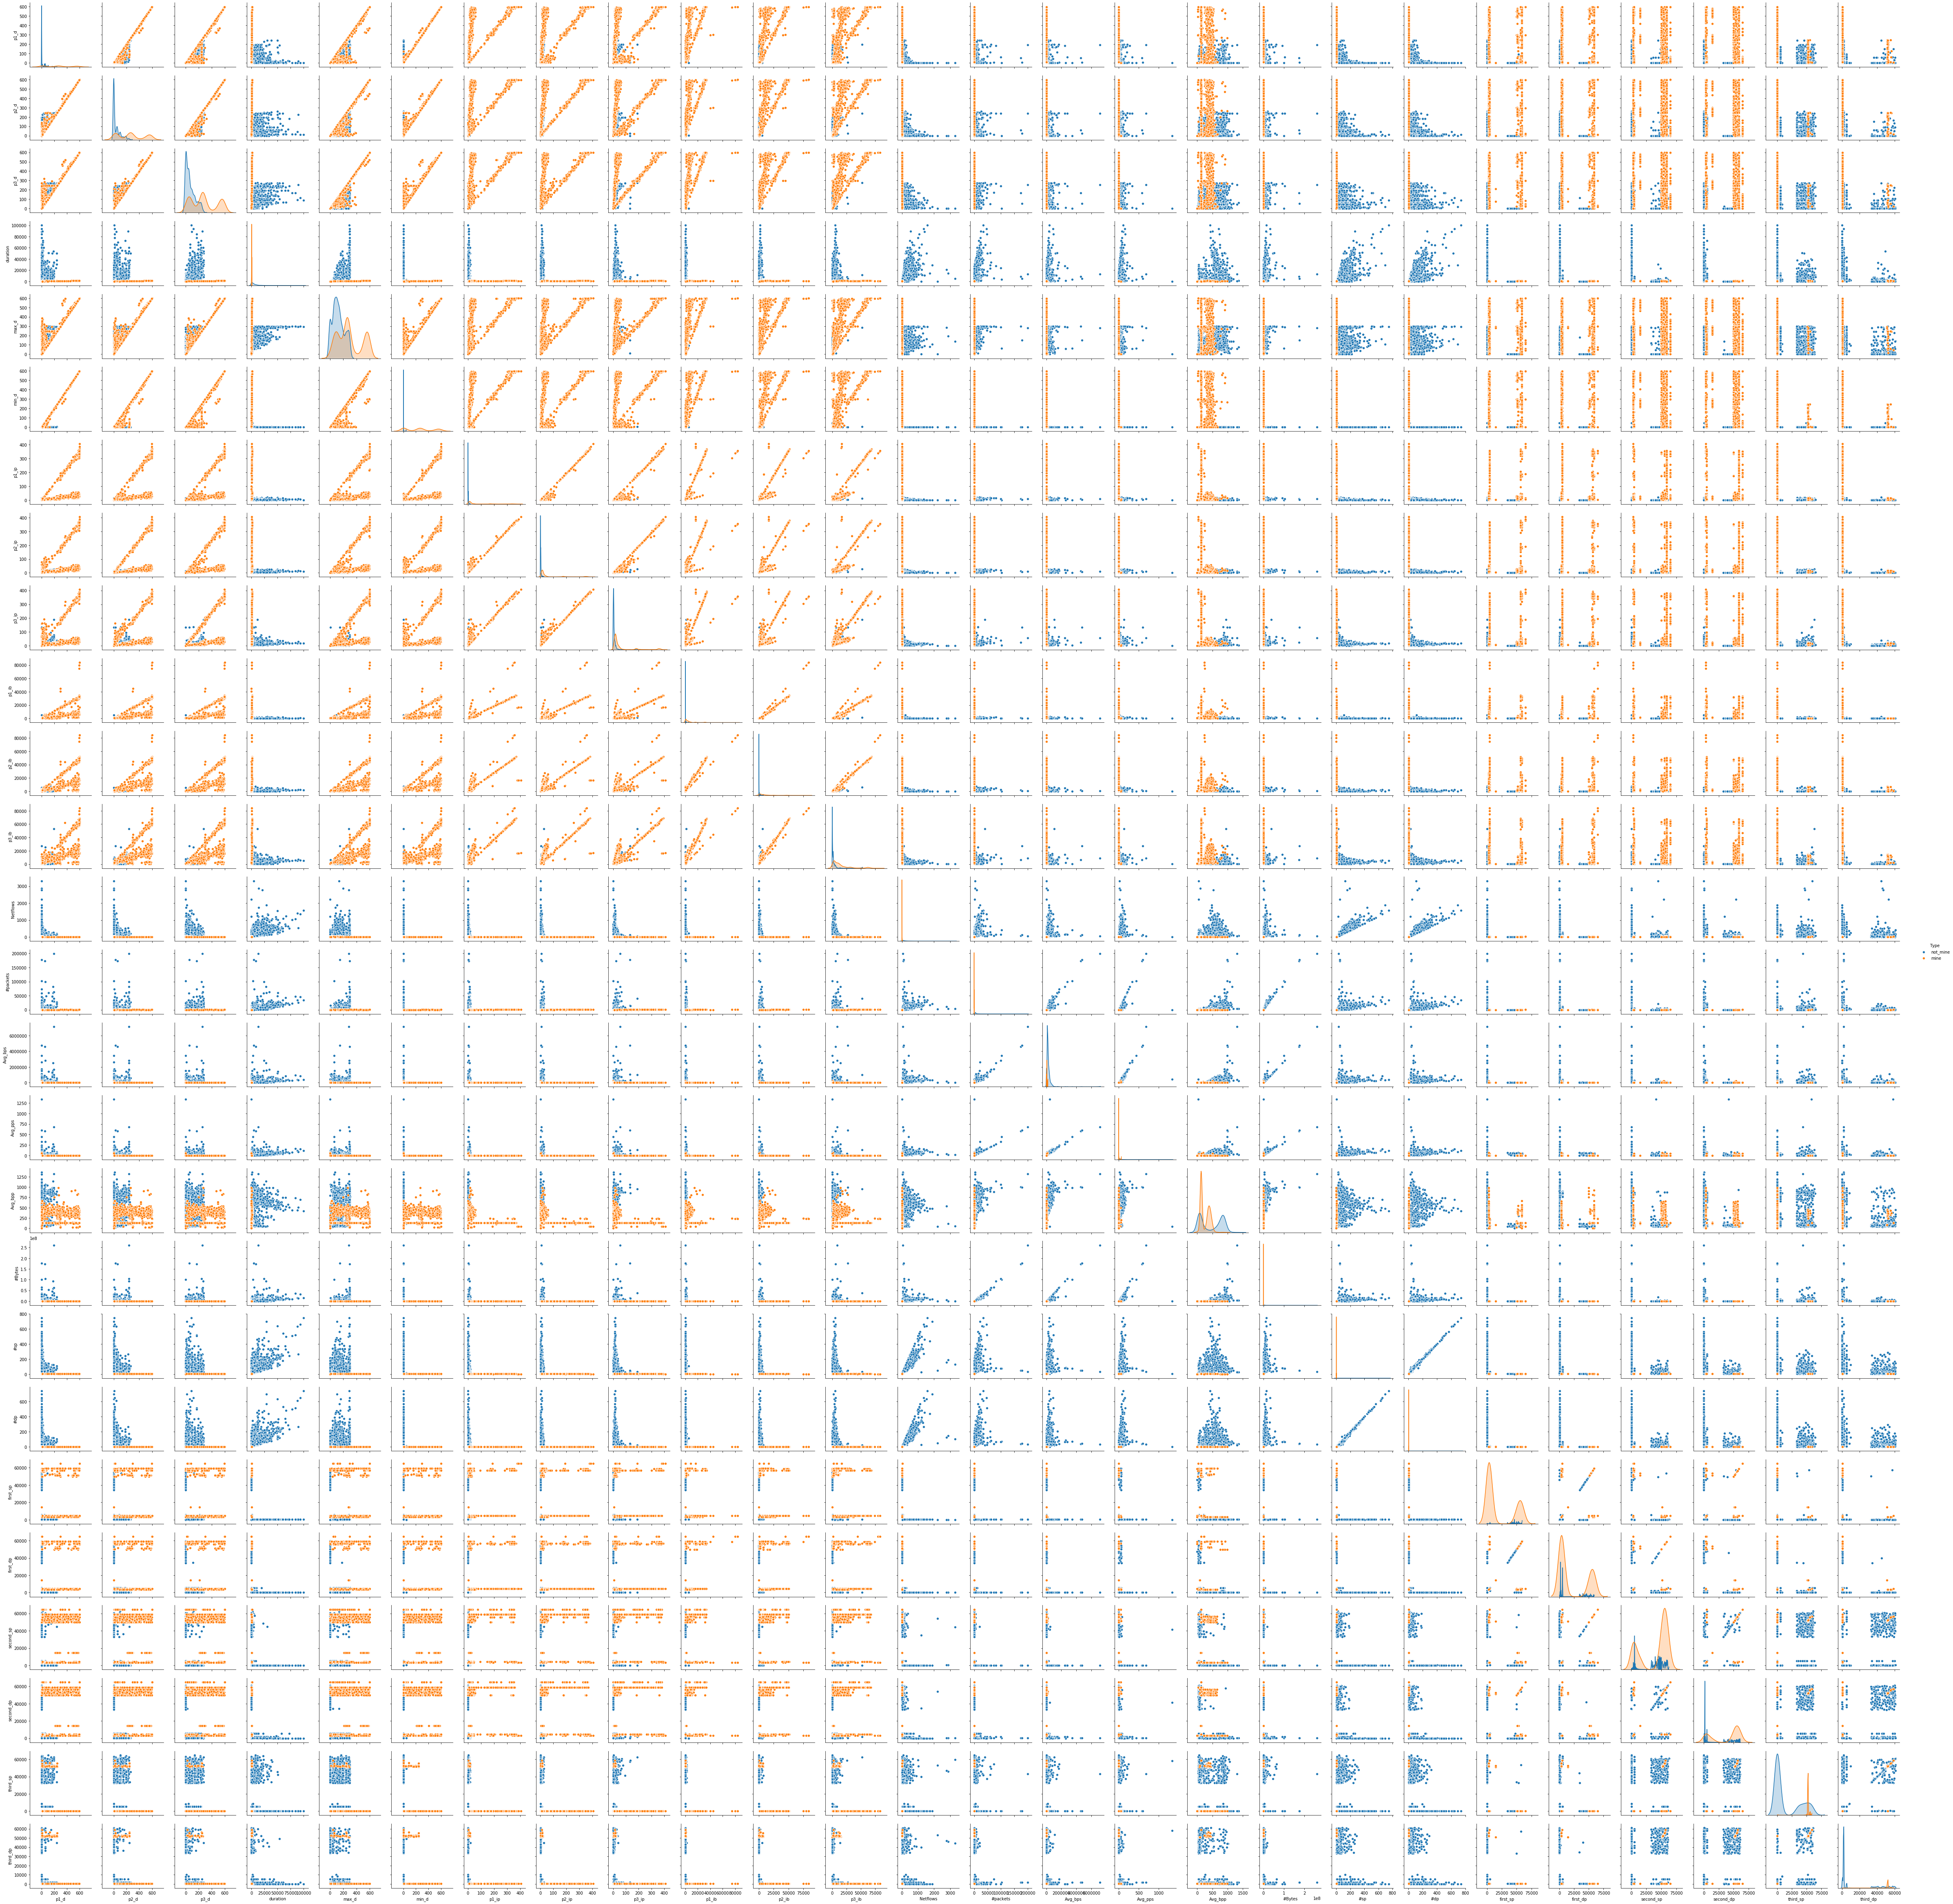

In [6]:
sns.pairplot(data_n, hue='Type')

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector

In [18]:
data_discreta + data_continua

['Netflows',
 '#packets',
 'Avg_bps',
 'Avg_pps',
 'Avg_bpp',
 '#Bytes',
 '#sp',
 '#dp',
 'first_sp',
 'first_dp',
 'second_sp',
 'second_dp',
 'third_sp',
 'third_dp',
 'p1_d',
 'p2_d',
 'p3_d',
 'duration',
 'max_d',
 'min_d',
 'p1_ip',
 'p2_ip',
 'p3_ip',
 'p1_ib',
 'p2_ib',
 'p3_ib']

In [19]:
preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), data_discreta + data_continua),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), data_categorica)],
                remainder='passthrough')

In [21]:
X = preprocessor.fit_transform(data)

In [23]:
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names(data_categorica)

In [28]:
labels = np.concatenate([data_discreta + data_continua, encoded_cat])
datos_train_prep = preprocessor.transform(data)
datos_train_prep = pd.DataFrame(datos_train_prep, columns=labels)
datos_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4733 entries, 0 to 4732
Data columns (total 38 columns):
Netflows                        4733 non-null float64
#packets                        4733 non-null float64
Avg_bps                         4733 non-null float64
Avg_pps                         4733 non-null float64
Avg_bpp                         4733 non-null float64
#Bytes                          4733 non-null float64
#sp                             4733 non-null float64
#dp                             4733 non-null float64
first_sp                        4733 non-null float64
first_dp                        4733 non-null float64
second_sp                       4733 non-null float64
second_dp                       4733 non-null float64
third_sp                        4733 non-null float64
third_dp                        4733 non-null float64
p1_d                            4733 non-null float64
p2_d                            4733 non-null float64
p3_d                         

In [72]:
sc = StandardScaler()
X_std_pca = sc.fit_transform(datos_train_prep)
pca = decomposition.PCA(n_components=8)
X_std_pca = pca.fit_transform(X_std_pca)
X_std_pca.shape

(4733, 8)

array([[ 7.20728403,  6.59082384, -2.71072016, ..., 13.44056722,
         1.75300454, -2.44932105],
       [-0.79988981, -1.99590004,  0.7661865 , ...,  0.42722753,
         0.94770627, -0.28863281],
       [-0.28276445, -2.57287604,  0.42401196, ..., -0.31652735,
         0.95792165,  2.53765666],
       ...,
       [-2.29717436, -0.99198101,  1.56108623, ..., -0.40652099,
        -0.13285336, -0.53809496],
       [ 3.66185609,  2.23415776,  0.70740458, ...,  0.78107766,
        -1.23205327, -0.12041943],
       [ 2.83116984,  0.43430792,  0.33132039, ..., -0.32989135,
        -1.54146766,  0.20591486]])